In [43]:
import pandas as pd 
df=pd.read_csv("../input/labeled-oliveoil/labeled_olive_oil.csv")
df.head()
new_df = df.copy()
features=df.columns
cluster_dict = {}
for cluster, group in new_df.groupby('cluster'):
    adjectives = list(group['cluster_adjectives'])
    cluster_dict[cluster] = adjectives[0]
cluster_dict
#first im going to load my dataframe create a copy of it and save the cluster numbers and the corresponding adjectives in a dictionary

{0: 'linoleic: high palmitic: high palmitoleic: high',
 1: 'region_Umbria: high macro.area_Centre.North: high oleic: high',
 2: 'arachidic: high macro.area_Sardinia: high linoleic: high',
 3: 'linolenic: high eicosenoic: high stearic: high',
 4: 'linolenic: high oleic: high eicosenoic: high',
 5: 'stearic: high region_Liguria.west: high oleic: high'}

In [45]:
new_df = df.drop('cluster_adjectives', axis=1)
#im going to perform stratified sampling on the data to make sure that the data is representative of the population 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(new_df.drop('cluster', axis=1), new_df['cluster'], test_size=0.2, stratify=new_df['cluster'], random_state=42)

In [46]:
#now im going to preproces the training data , im just going to encode the categorical variables and scale the numerical variables as i did with the previous notebook
from sklearn.preprocessing import StandardScaler
numerical_features=['palmitic', 'palmitoleic', 'stearic', 'oleic', 'linoleic', 'linolenic', 'arachidic', 'eicosenoic']
categorical_features=['macro.area', 'region']
def scale_features(df,numerical_features):
    scaler=StandardScaler()
    scaled_df=df.copy()
    scaled_df[numerical_features] = scaler.fit_transform(scaled_df[numerical_features])
    return scaled_df,scaler
def encode_features(df, categorical_features):
    encoded_df = pd.get_dummies(df, columns=categorical_features)
    return encoded_df
scaled_df,scaler=scale_features(X_train,numerical_features)
encoded_X = encode_features(scaled_df,categorical_features)
scaled_test_X=scaler.transform(X_test[numerical_features])
encoded_test_X = encode_features(X_test,categorical_features)
#okay now we are done with preprocessing both of our training and testing sets while paying attention to fitting the scaler only to the training set to avoid data leakage 

In [47]:
#first we are going to start with KNN 
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(encoded_X, y_train)
knn_pred = knn.predict(encoded_test_X)

In [48]:
#second the decision tree classifier
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(encoded_X, y_train)
dt_pred = dt.predict(encoded_test_X)

In [49]:
#third the SVM classifier , im just going to use a linear kernel for now
from sklearn.svm import SVC
svm = SVC(kernel='linear')
svm.fit(encoded_X, y_train)
svm_pred = svm.predict(encoded_test_X)

In [51]:
#and finally the MLP classifier
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(10,10), max_iter=500)
mlp.fit(encoded_X, y_train)
mlp_pred = mlp.predict(encoded_test_X)

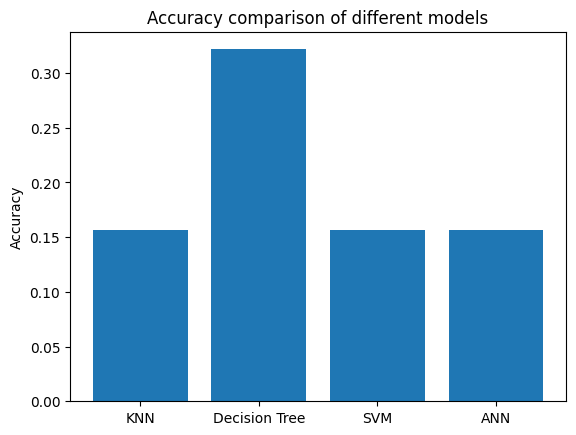

In [52]:
#im going to make a comparative table for the four classifiers before optimizing them
from sklearn.metrics import accuracy_score
accuracy_scores = {"KNN":accuracy_score(y_test,knn_pred), "Decision Tree":accuracy_score(y_test,dt_pred), "SVM":accuracy_score(y_test,svm_pred), "ANN":accuracy_score(y_test,mlp_pred)}
import matplotlib.pyplot as plt
plt.bar(range(len(accuracy_scores)), list(accuracy_scores.values()), align='center')
plt.xticks(range(len(accuracy_scores)), list(accuracy_scores.keys()))
plt.ylabel('Accuracy')
plt.title('Accuracy comparison of different models')
plt.show()
#the predictions are soo bad , im going to try to optimize the models to see if i can get better results and for that im going to use grid search to find the best parameters for each model

In [53]:
from sklearn.model_selection import GridSearchCV
knn1 = KNeighborsClassifier()
param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}
grid_search = GridSearchCV(knn1, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(encoded_X, y_train)
print(f"Best KNN accuracy: {grid_search.best_score_} with parameters: {grid_search.best_params_}")
knn1=grid_search.best_estimator_

Best KNN accuracy: 0.9846631629240324 with parameters: {'n_neighbors': 5}


In [54]:
from sklearn.tree import DecisionTreeClassifier

dt1 = DecisionTreeClassifier()
param_grid = {'max_depth': [5, 10, 15, 20]}
grid_search = GridSearchCV(dt1, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(encoded_X, y_train)
print(f"Best decision tree accuracy: {grid_search.best_score_} with parameters: {grid_search.best_params_}")
dt1=grid_search.best_estimator_

Best decision tree accuracy: 0.9540850453893933 with parameters: {'max_depth': 10}


In [55]:
from sklearn.svm import SVC

svm1 = SVC()
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [0.1, 1, 10]}
grid_search = GridSearchCV(svm1, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(encoded_X, y_train)
print(f"Best SVM accuracy: {grid_search.best_score_} with parameters: {grid_search.best_params_}")
svm1=grid_search.best_estimator_

Best SVM accuracy: 0.9934065934065934 with parameters: {'C': 10, 'gamma': 0.1}


In [56]:
from sklearn.neural_network import MLPClassifier
mlp1 = MLPClassifier()
param_grid = {'hidden_layer_sizes': [(10,), (50,), (100,)], 'alpha': [0.0001, 0.001, 0.01]}
grid_search = GridSearchCV(mlp1, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(encoded_X, y_train)
print(f"Best MLP accuracy: {grid_search.best_score_} with parameters: {grid_search.best_params_}")
mlp1=grid_search.best_estimator_

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptro

Best MLP accuracy: 0.9890348781653129 with parameters: {'alpha': 0.01, 'hidden_layer_sizes': (100,)}


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


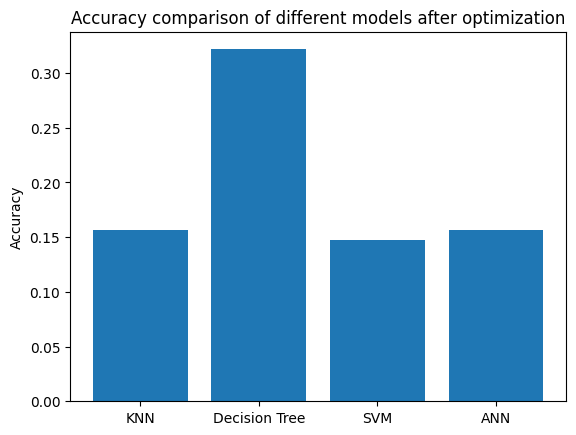

In [57]:
knn_predictions = knn1.predict(encoded_test_X)
dt_predictions = dt1.predict(encoded_test_X)
svm_predictions = svm1.predict(encoded_test_X)
mlp_predictions = mlp1.predict(encoded_test_X)
optimized_accuracy_scores = {"KNN":accuracy_score(y_test,knn_predictions), "Decision Tree":accuracy_score(y_test,dt_predictions), "SVM":accuracy_score(y_test,svm_predictions), "ANN":accuracy_score(y_test,mlp_predictions)}
plt.bar(range(len(optimized_accuracy_scores)), list(optimized_accuracy_scores.values()), align='center')
plt.xticks(range(len(optimized_accuracy_scores)), list(optimized_accuracy_scores.keys()))
plt.ylabel('Accuracy')
plt.title('Accuracy comparison of different models after optimization')
plt.show()
#im still not satisfied with the results i got but i think its the best i can do with the data i have , i think the problem is that the data is not enough to make good predictions
#i think the best way to improve the results is to get more data and to get more features that are more related to the target variable
#im going to try XGBoost to see if i can get better results

In [58]:
#XGBoost implementation
from xgboost import XGBClassifier
xgb = XGBClassifier()
params = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0]
}
grid_search = GridSearchCV(xgb, params, cv=5, scoring='accuracy')
grid_search.fit(encoded_X, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
xgb_best = XGBClassifier(**best_params)
xgb_best.fit(encoded_X, y_train)
test_pred = xgb_best.predict(encoded_test_X)
accuracy = accuracy_score(y_test, test_pred)